# 1 使用BDMLtools做策略分析报告 <font size=3 >by 曾珂</font>

In [1]:
import BDMLtools as bm
import pandas as pd
import numpy as np

In [2]:
bm.__version__

'0.2.0'

+ load germancredit data

In [3]:
import scorecardpy as sc
dt=sc.germancredit().copy()
dt['creditability']=dt['creditability'].map({'good':0,'bad':1})

+ 将germancredit的数据类型进行指定
    + num列-->float64
    + str列-->object
    + date列-->datetime

In [4]:
dtypes_dict={
    'num':['age.in.years',
         'credit.amount',
         'creditability',
         'duration.in.month',
         'installment.rate.in.percentage.of.disposable.income',
         'number.of.existing.credits.at.this.bank',
         'number.of.people.being.liable.to.provide.maintenance.for',
         'present.residence.since'],
    'str':['housing','telephone','foreign.worker','purpose','job','personal.status.and.sex','property',
           'credit.history','savings.account.and.bonds','present.employment.since',
           'status.of.existing.checking.account',
           'other.installment.plans','other.debtors.or.guarantors'],
    'date':[]
}

In [5]:
da=bm.dtypeAllocator(dtypes_dict=dtypes_dict).fit(dt)
dt=da.transform(dt)
X=dt.drop('creditability',axis=1)
y=dt['creditability']

## 1.1 BDMLtools中的报告

实践进行策略分析时，有时希望快速生成策略特征的分析报告,BDMLtools提供了三种特征分析库:
    
+ varReport:特征分析报告
+ varReportSinge:单特征分析报告
+ varGroupsReport:组特征分析报告

## 1.2 varReport

### 1.2.1 基本用法

一般特征分析需先进行分箱再生成报告,这里使用binSelector进行最优分箱

In [6]:
bin_tree=bm.binSelector(method='tree',bin_num_limit=5,n_jobs=1,iv_limit=0,coerce_monotonic=True).fit(X,y)

+ bin_tree中的属性breaks_list为分箱字典,包含了所有特征的分箱结果,格式与scorecardpy一致
+ 将breaks_list作为varReport的入参以按照指定的breaks_list分箱产生特征分析报告

In [7]:
vtab=bm.varReport(bin_tree.breaks_list,n_jobs=1).fit(X,y)

+ vtab的var_report_dict保存了所有特征的分箱结果,结构与scorecardpy一致

In [8]:
vtab.var_report_dict.keys()

dict_keys(['age.in.years', 'credit.amount', 'credit.history', 'duration.in.month', 'foreign.worker', 'housing', 'installment.rate.in.percentage.of.disposable.income', 'job', 'number.of.existing.credits.at.this.bank', 'number.of.people.being.liable.to.provide.maintenance.for', 'other.debtors.or.guarantors', 'other.installment.plans', 'personal.status.and.sex', 'present.employment.since', 'present.residence.since', 'property', 'purpose', 'savings.account.and.bonds', 'status.of.existing.checking.account', 'telephone'])

In [9]:
vtab.var_report_dict['credit.amount']

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 4000.0)",credit.amount,754,0.754,559.0,195.0,0.258621,-0.205852,0.030584,0.141682,0.148571,0.148571,4000.0
"[4000.0, 6800.0)",credit.amount,133,0.133,83.0,50.0,0.375940,0.340480,0.016375,0.141682,0.100476,0.148571,6800.0
"[6800.0, 9200.0)",credit.amount,63,0.063,37.0,26.0,0.412698,0.494476,0.016718,0.141682,0.066667,0.148571,9200.0
"[9200.0, inf)",credit.amount,50,0.050,21.0,29.0,0.580000,1.170071,0.078005,0.141682,0.000000,0.148571,inf
special,credit.amount,0,0.000,0.0,0.0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,special
missing,credit.amount,0,0.000,0.0,0.0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,missing


这里每一个报表中bin索引,
+ 存在missing行用于标示缺失值,数据中的np.nan将被计算进缺失值行中,若数据没有缺失值则为默认值
+ special行用于标示除缺失值外的特殊编码,可通过special_values参数进行指定,若数据没有特殊值则为默认值,详情请见文档

In [10]:
pd.concat(vtab.var_report_dict)

variable  \
                                    bin                                                                             
age.in.years                        [-inf, 26.0)                                                     age.in.years   
                                    [26.0, 30.0)                                                     age.in.years   
                                    [30.0, 35.0)                                                     age.in.years   
                                    [35.0, inf)                                                      age.in.years   
                                    special                                                          age.in.years   
...                                                                                                           ...   
status.of.existing.checking.account missing                                   status.of.existing.checking.account   
telephone                           yes, registered under the customers name                            telephone   
                                    none                                                                telephone   
                                    special                                                             telephone   
                                    missing                                                             telephone   

                                                                              count  \
                                    bin                                               
age.in.years                        [-inf, 26.0)                                190   
                                    [26.0, 30.0)                                181   
                                    [30.0, 35.0)                                177   
                                    [35.0, inf)                                 452   
                                    special                                       0   
...                                                                             ...   
status.of.existing.checking.account missing                                       0   
telephone                           yes, registered under the customers name    404   
                                    none                                        596   
                                    special                                       0   
                                    missing                                       0   

                                                                              count_distr  \
                                    bin                                                     
age.in.years                        [-inf, 26.0)                                    0.190   
                                    [26.0, 30.0)                                    0.181   
                                    [30.0, 35.0)                                    0.177   
                                    [35.0, inf)                                     0.452   
                                    special                                         0.000   
...                                                                                   ...   
status.of.existing.checking.account missing                                         0.000   
telephone                           yes, registered under the customers name        0.404   
                                    none                                            0.596   
                                    special                                         0.000   
                                    missing                                         0.000   

                                                                               good  \
                                    bin                                               
age.in.years                        [-inf, 26.0)                   

使用pd.concat形成所有特征的特征分析报告,与scorecardpy一致

### 1.2.2 样本权重

若数据是经过抽样获取的，一般希望通过样本加权建模以利于还原其违约概率

+ 加入样本权重后各个分箱的坏样本率会产生一定变化
+ 加入样本权重后各个分箱的iv,ks也会产生变化(若只对好坏样本加权且breaks一致则无变化,因为好坏分布未变化)

BDMLtools的报告支持加入样本权重

In [11]:
sample_weight=pd.Series(y.map({0:10,1:1}),index=y.index) #假定数据经过抽样后好样本权重为10,坏样本权重为1
sample_weight_oth=pd.Series(np.random.randint(0,100,y.size)/100,index=y.index) #模拟复杂抽样情形下的样本权重

In [12]:
vtab_ws=bm.varReport(bin_tree.breaks_list,n_jobs=1,sample_weight=sample_weight).fit(X,y)
vtab_ws_oth=bm.varReport(bin_tree.breaks_list,n_jobs=1,sample_weight=sample_weight_oth).fit(X,y)

In [13]:
vtab_ws.var_report_dict['credit.amount'] #加权后(仅类加权)

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 4000.0)",credit.amount,5785,0.792466,5590.0,195.0,0.033708,-0.205852,0.030584,0.141682,0.148571,0.148571,4000.0
"[4000.0, 6800.0)",credit.amount,880,0.120548,830.0,50.0,0.056818,0.340480,0.016375,0.141682,0.100476,0.148571,6800.0
"[6800.0, 9200.0)",credit.amount,396,0.054247,370.0,26.0,0.065657,0.494476,0.016718,0.141682,0.066667,0.148571,9200.0
"[9200.0, inf)",credit.amount,239,0.032740,210.0,29.0,0.121339,1.170071,0.078005,0.141682,0.000000,0.148571,inf
special,credit.amount,0,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,special
missing,credit.amount,0,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,missing


In [14]:
vtab_ws_oth.var_report_dict['credit.amount'] #加权后(样本加权)

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 4000.0)",credit.amount,365.15,0.758627,274.46,90.69,0.248364,-0.266098,0.050735,0.224431,0.190663,0.190663,4000.0
"[4000.0, 6800.0)",credit.amount,60.09,0.124842,34.17,25.92,0.431353,0.564927,0.043582,0.224431,0.113516,0.190663,6800.0
"[6800.0, 9200.0)",credit.amount,35.43,0.073609,20.65,14.78,0.417161,0.506820,0.020538,0.224431,0.072992,0.190663,9200.0
"[9200.0, inf)",credit.amount,20.66,0.042923,7.04,13.62,0.659245,1.501192,0.109575,0.224431,0.000000,0.190663,inf
special,credit.amount,0.00,0.000000,0.00,0.00,NaN,0.000000,0.000000,0.224431,0.000000,0.190663,special
missing,credit.amount,0.00,0.000000,0.00,0.00,NaN,0.000000,0.000000,0.224431,0.000000,0.190663,missing


In [15]:
vtab.var_report_dict['credit.amount'] #未加权

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 4000.0)",credit.amount,754,0.754,559.0,195.0,0.258621,-0.205852,0.030584,0.141682,0.148571,0.148571,4000.0
"[4000.0, 6800.0)",credit.amount,133,0.133,83.0,50.0,0.375940,0.340480,0.016375,0.141682,0.100476,0.148571,6800.0
"[6800.0, 9200.0)",credit.amount,63,0.063,37.0,26.0,0.412698,0.494476,0.016718,0.141682,0.066667,0.148571,9200.0
"[9200.0, inf)",credit.amount,50,0.050,21.0,29.0,0.580000,1.170071,0.078005,0.141682,0.000000,0.148571,inf
special,credit.amount,0,0.000,0.0,0.0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,special
missing,credit.amount,0,0.000,0.0,0.0,NaN,0.000000,0.000000,0.141682,0.000000,0.148571,missing


### 1.2.3 并行

varReport使用joblib对列的报告生成进行了并行优化,
+ 当基础的数据量非常大列较多时可通过设定n_jobs=任务数进行并行以提高运行速度
+ 一般情况下建议n_jobs=1

In [57]:
#模拟较大大数据量,3w行1000个特征
X_big=pd.DataFrame(np.random.rand(30000,1000),columns=['f'+str(i) for i in range(1000)])
y_big=pd.Series(np.random.randint(0,2,30000),name='target')
breaks_list_big={col:[0.2,0.4,0.6,0.8] for col in X_big.columns}

In [58]:
%%time
res_p=bm.varReport(breaks_list_big,n_jobs=-1).fit(X_big,y_big) 

CPU times: user 1.43 s, sys: 159 ms, total: 1.59 s
Wall time: 7.1 s


In [59]:
%%time
res=bm.varReport(breaks_list_big,n_jobs=1).fit(X_big,y_big)

CPU times: user 15 s, sys: 148 ms, total: 15.1 s
Wall time: 15.3 s


In [60]:
#结果一致
pd.concat(res.var_report_dict).equals(pd.concat(res_p.var_report_dict))

True

### 1.2.4 批量的特征分析报告绘图 

实例varReport的方法woe_plot可以根据分箱结果进行批量的绘图并输出

In [20]:
vtab=bm.varReport(bin_tree.breaks_list,n_jobs=1).fit(X,y)

vtab_figs_dict=vtab.woe_plot(n_jobs=1)

geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


特征分析报告中若特征分箱后只有一箱，那么会产生以上警告信息，此类信息可忽略，字典对象vtab_figs_dict存储了报告绘图的输出

In [21]:
vtab_figs_dict

{'age.in.years': <Figure size 640x480 with 2 Axes>,
 'credit.amount': <Figure size 640x480 with 2 Axes>,
 'credit.history': <Figure size 640x480 with 2 Axes>,
 'duration.in.month': <Figure size 640x480 with 2 Axes>,
 'foreign.worker': <Figure size 640x480 with 2 Axes>,
 'housing': <Figure size 640x480 with 2 Axes>,
 'installment.rate.in.percentage.of.disposable.income': <Figure size 640x480 with 2 Axes>,
 'job': <Figure size 640x480 with 2 Axes>,
 'number.of.existing.credits.at.this.bank': <Figure size 640x480 with 2 Axes>,
 'number.of.people.being.liable.to.provide.maintenance.for': <Figure size 640x480 with 2 Axes>,
 'other.debtors.or.guarantors': <Figure size 640x480 with 2 Axes>,
 'other.installment.plans': <Figure size 640x480 with 2 Axes>,
 'personal.status.and.sex': <Figure size 640x480 with 2 Axes>,
 'present.employment.since': <Figure size 640x480 with 2 Axes>,
 'present.residence.since': <Figure size 640x480 with 2 Axes>,
 'property': <Figure size 640x480 with 2 Axes>,
 'purp

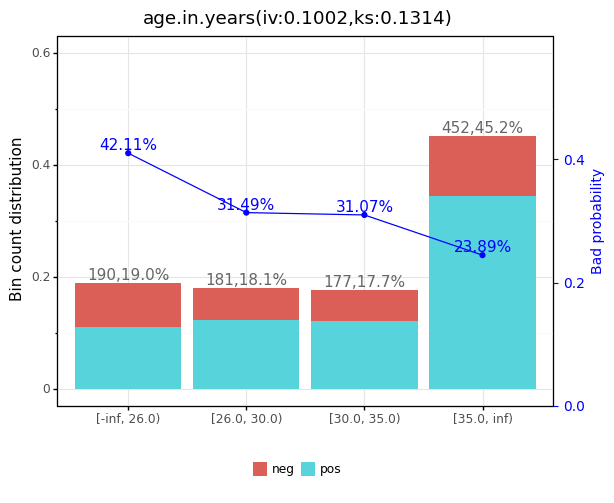

In [22]:
vtab_figs_dict['age.in.years']

BDMLtools使用plotnine作为绘图包产生woe_plot
+ plotnine作为ggplot2在python的实现，绘图语法与R的ggplot2一致
+ 特征分析报告中柱状图为各个bin好坏样本的count_dist
+ 特征分析报告中折线图为各个bin的坏样本率
+ 当前版本的作图基于plotnine-0.8，其不支持双轴图，因此坏样本率与count_dist目前共用一个y轴，在极端情况下(count_dist与坏样本率相差过大)的结果会不理想，BDMLtools将持续跟进plotnine的更新

## 1.3 varReportSinge

### 1.3.1 基本用法

对单一特征产生报告可用bm.varReportSinge,其可以灵活得调整分箱

In [23]:
bm.varReportSinge().report(X['age.in.years'],y,[26,30,35])

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 26.0)",age.in.years,190,0.190,110.0,80.0,0.421053,0.528844,0.057921,0.100182,0.109524,0.131429,26.0
"[26.0, 30.0)",age.in.years,181,0.181,124.0,57.0,0.314917,0.070068,0.000901,0.100182,0.122381,0.131429,30.0
"[30.0, 35.0)",age.in.years,177,0.177,122.0,55.0,0.310734,0.050610,0.000458,0.100182,0.131429,0.131429,35.0
"[35.0, inf)",age.in.years,452,0.452,344.0,108.0,0.238938,-0.311213,0.040902,0.100182,0.000000,0.131429,inf
special,age.in.years,0,0.000,0.0,0.0,NaN,0.000000,0.000000,0.100182,0.000000,0.131429,special
missing,age.in.years,0,0.000,0.0,0.0,NaN,0.000000,0.000000,0.100182,0.000000,0.131429,missing


In [24]:
bm.varReportSinge().report(X['age.in.years'],y,[26,35])

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 26.0)",age.in.years,190,0.190,110.0,80.0,0.421053,0.528844,0.057921,0.100148,0.109524,0.131429,26.0
"[26.0, 35.0)",age.in.years,358,0.358,246.0,112.0,0.312849,0.060465,0.001324,0.100148,0.131429,0.131429,35.0
"[35.0, inf)",age.in.years,452,0.452,344.0,108.0,0.238938,-0.311213,0.040902,0.100148,0.000000,0.131429,inf
special,age.in.years,0,0.000,0.0,0.0,NaN,0.000000,0.000000,0.100148,0.000000,0.131429,special
missing,age.in.years,0,0.000,0.0,0.0,NaN,0.000000,0.000000,0.100148,0.000000,0.131429,missing


### 1.3.2 样本权重

当然也支持样本权重

In [25]:
sample_weight=pd.Series(y.map({0:10,1:1}),index=y.index)
bm.varReportSinge().report(X['age.in.years'],y,[26,30,35],sample_weight)

,variable,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,ks,ks_max,breaks
bin,,,,,,,,,,,,
"[-inf, 26.0)",age.in.years,1180,0.161644,1100.0,80.0,0.067797,0.528844,0.057921,0.100182,0.109524,0.131429,26.0
"[26.0, 30.0)",age.in.years,1297,0.177671,1240.0,57.0,0.043948,0.070068,0.000901,0.100182,0.122381,0.131429,30.0
"[30.0, 35.0)",age.in.years,1275,0.174658,1220.0,55.0,0.043137,0.050610,0.000458,0.100182,0.131429,0.131429,35.0
"[35.0, inf)",age.in.years,3548,0.486027,3440.0,108.0,0.030440,-0.311213,0.040902,0.100182,0.000000,0.131429,inf
special,age.in.years,0,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.100182,0.000000,0.131429,special
missing,age.in.years,0,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.100182,0.000000,0.131429,missing


### 1.3.2 单特征分析报告绘图

方法woe_plot可支持绘制特征分析报告

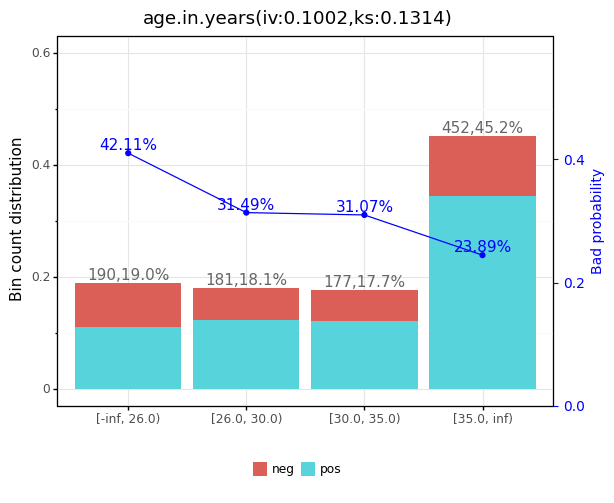

In [26]:
tab,fig,breaks=bm.varReportSinge().woe_plot(X['age.in.years'],y,[26,30,35],show_plot=True)

使用方法woe_plot进行单特征的分箱调整会更加直观与方便

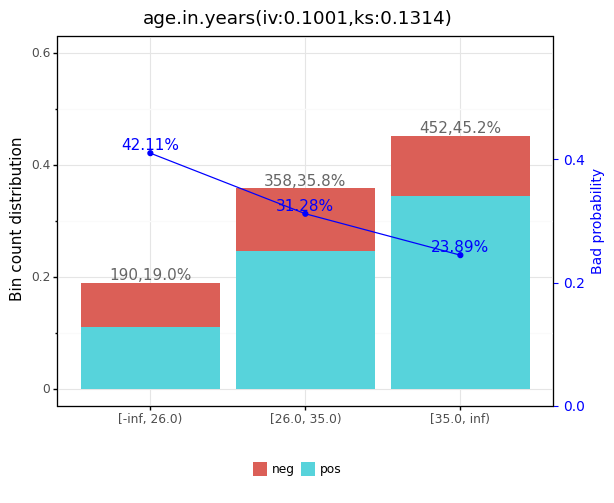

In [27]:
tab,fig,breaks=bm.varReportSinge().woe_plot(X['age.in.years'],y,[26,35],show_plot=True)

In [28]:
print(breaks)
print(tab)

[26, 35]
                  variable  count  count_distr   good    bad   badprob  \
bin                                                                      
[-inf, 26.0)  age.in.years    190        0.190  110.0   80.0  0.421053   
[26.0, 35.0)  age.in.years    358        0.358  246.0  112.0  0.312849   
[35.0, inf)   age.in.years    452        0.452  344.0  108.0  0.238938   
special       age.in.years      0        0.000    0.0    0.0       NaN   
missing       age.in.years      0        0.000    0.0    0.0       NaN   

                   woe    bin_iv  total_iv        ks    ks_max   breaks  
bin                                                                      
[-inf, 26.0)  0.528844  0.057921  0.100148  0.109524  0.131429     26.0  
[26.0, 35.0)  0.060465  0.001324  0.100148  0.131429  0.131429     35.0  
[35.0, inf)  -0.311213  0.040902  0.100148  0.000000  0.131429      inf  
special       0.000000  0.000000  0.100148  0.000000  0.131429  special  
missing       0.000000  0.00

## 1.4 varGroupsReport

在实践中,单一的特征分析报告往往仍旧无法满足实际需要,往往希望通过不同的月份\产品\客群查看各个策略的表现,那么就需要分组产生分析报告

varGroupsReport就是用来满足这种需要的

### 1.4.1 基本用法

In [29]:
#模拟月份(9,10,11,12月),模拟客群(3个)

X_all=X.join(y).assign(
    month=np.random.randint(9,13,y.size),
    client_group=pd.Series(np.random.randint(0,3,y.size),index=y.index).map({0:'g1',1:'g2',2:'g3'})
)

In [30]:
vtab_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['month','client_group'],target=y.name,row_limit=0,
                          n_jobs=1).fit(X_all)

vtab_g中共五张报表:
+ report_all:各个组的特征报告
+ report_brief:各个组的简化版报告,只保留count,badprob,woe,total_iv,ks_max
+ report_count:各个组的简化版报告,只保留count
+ report_badprob:各个组的简化版报告,只保留badprob
+ report_iv:各个组的简化版报告,只保留total_iv
+ report_ks:各个组的简化版报告,只保留ks_max

以report_brief为例

In [31]:
vtab_g.report_dict['report_brief'][['variable','bin','10']] #只看10月份的报告

variable  \
                                           
                                           
0                           age.in.years   
1                           age.in.years   
2                           age.in.years   
3                           age.in.years   
4                           age.in.years   
..                                   ...   
101  status.of.existing.checking.account   
102                            telephone   
103                            telephone   
104                            telephone   
105                            telephone   

                                          bin    10                      \
                                                 g1                       
                                              count   badprob       woe   
0                                [-inf, 26.0)    12  0.416667  0.267063   
1                                [26.0, 30.0)    19  0.368421  0.064539   
2                                [30.0, 35.0)    19  0.421053  0.285081   
3                                 [35.0, inf)    49  0.306122 -0.214775   
4                                     special     0       NaN  0.000000   
..                                        ...   ...       ...       ...   
101                                   missing     0       NaN  0.000000   
102  yes, registered under the customers name    43  0.395349  0.178652   
103                                      none    56  0.321429 -0.143679   
104                                   special     0       NaN  0.000000   
105                                   missing     0       NaN  0.000000   

                                                                             \
                           g2                                            g3   
     total_iv    ks_max count   badprob       woe  total_iv    ks_max count   
0    0.047964  0.102679    11  0.454545  0.287682  0.370075  0.283333    18   
1    0.047964  0.102679    11  0.454545  0.287682  0.370075  0.283333    17   
2    0.047964  0.102679    19  0.578947  0.788457  0.370075  0.283333     9   
3    0.047964  0.102679    37  0.243243 -0.664976  0.370075  0.283333    35   
4    0.047964  0.102679     0       NaN  0.000000  0.370075  0.283333     0   
..        ...       ...   ...       ...       ...       ...       ...   ...   
101  0.874189  0.425000     0       NaN  0.000000  0.815518  0.395833     0   
102  0.025614  0.079464    35  0.228571 -0.746392  0.373612  0.295833    32   
103  0.025614  0.079464    43  0.511628  0.516524  0.373612  0.295833    47   
104  0.025614  0.079464     0       NaN  0.000000  0.373612  0.295833     0   
105  0.025614  0.079464     0       NaN  0.000000  0.373612  0.295833     0   

                                             
                                             
      badprob       woe  total_iv    ks_max  
0    0.166667 -0.074108  0.121252  0.156044  
1    0.117647 -0.479573  0.121252  0.156044  
2    0.111111 -0.544112  0.121252  0.156044  
3    0.228571  0.318935  0.121252  0.156044  
4         NaN  0.000000  0.121252  0.156044  
..        ...       ...       ...       ...  
101       NaN  0.000000  0.526791  0.325275  
102  0.093750 -0.733354  0.251127  0.231868  
103  0.234043  0.349706  0.251127  0.231868  
104       NaN  0.000000  0.251127  0.231868  
105       NaN  0.000000  0.251127  0.231868  

[106 rows x 17 columns]

In [32]:
vtab_g.report_dict['report_brief'] #全部报告

variable  \
                                           
                                           
0                           age.in.years   
1                           age.in.years   
2                           age.in.years   
3                           age.in.years   
4                           age.in.years   
..                                   ...   
101  status.of.existing.checking.account   
102                            telephone   
103                            telephone   
104                            telephone   
105                            telephone   

                                          bin    10                      \
                                                 g1                       
                                              count   badprob       woe   
0                                [-inf, 26.0)    12  0.416667  0.267063   
1                                [26.0, 30.0)    19  0.368421  0.064539   
2                                [30.0, 35.0)    19  0.421053  0.285081   
3                                 [35.0, inf)    49  0.306122 -0.214775   
4                                     special     0       NaN  0.000000   
..                                        ...   ...       ...       ...   
101                                   missing     0       NaN  0.000000   
102  yes, registered under the customers name    43  0.395349  0.178652   
103                                      none    56  0.321429 -0.143679   
104                                   special     0       NaN  0.000000   
105                                   missing     0       NaN  0.000000   

                                                   ...     9            \
                           g2                      ...    g2             
     total_iv    ks_max count   badprob       woe  ... count   badprob   
0    0.047964  0.102679    11  0.454545  0.287682  ...    15  0.533333   
1    0.047964  0.102679    11  0.454545  0.287682  ...    22  0.363636   
2    0.047964  0.102679    19  0.578947  0.788457  ...     8  0.125000   
3    0.047964  0.102679    37  0.243243 -0.664976  ...    44  0.204545   
4    0.047964  0.102679     0       NaN  0.000000  ...     0       NaN   
..        ...       ...   ...       ...       ...  ...   ...       ...   
101  0.874189  0.425000     0       NaN  0.000000  ...     0       NaN   
102  0.025614  0.079464    35  0.228571 -0.746392  ...    41  0.292683   
103  0.025614  0.079464    43  0.511628  0.516524  ...    48  0.291667   
104  0.025614  0.079464     0       NaN  0.000000  ...     0       NaN   
105  0.025614  0.079464     0       NaN  0.000000  ...     0       NaN   

                                                                       \
                                     g3                                 
          woe  total_iv    ks_max count   badprob       woe  total_iv   
0    1.018570  0.404182  0.282051    14  0.285714  0.064539  0.109896   
1    0.325422  0.404182  0.282051     9  0.444444  0.757686  0.109896   
2   -1.060872  0.404182  0.282051    15  0.200000 -0.405465  0.109896   
3   -0.473085  0.404182  0.282051    39  0.256410 -0.083881  0.109896   
4    0.000000  0.404182  0.282051     0       NaN  0.000000  0.109896   
..        ...       ...       ...   ...       ...       ...       ...   
101  0.000000  0.441413  0.286325     0       NaN  0.000000  0.841231   
102  0.002649  0.000006  0.001221    29  0.206897 -0.362905  0.069410   
103 -0.002265  0.000006  0.001221    48  0.312500  0.192372  0.069410   
104  0.000000  0.000006  0.001221     0       NaN  0.000000  0.069410   
105  0.000000  0.000006  0.001221     0       NaN  0.000000  0.069410   

               
               
       ks_max  
0    0.113095  
1    0.113095  
2    0.113095  
3    0.113095  
4    0.113095  
..        ...  
101  0.398810  
102  0.125000  
103  0.125000  
104  0.125000  
105  0.125000  

[106 rows x 62 columns]

In [33]:
vtab_g.report_dict['report_ks']

variable        10            \
                                                             g1        g2   
                                                         ks_max    ks_max   
0                                        age.in.years  0.102679  0.283333   
1                                       credit.amount  0.266964  0.083333   
2                                      credit.history  0.270982  0.270833   
3                                   duration.in.month  0.193304  0.195833   
4                                      foreign.worker  0.000000  0.000000   
5                                             housing  0.051339  0.137500   
6   installment.rate.in.percentage.of.disposable.i...  0.120982  0.204167   
7                                                 job  0.111161  0.087500   
8             number.of.existing.credits.at.this.bank  0.045982  0.187500   
9   number.of.people.being.liable.to.provide.maint...  0.119196  0.066667   
10                        other.debtors.or.guarantors  0.018304  0.062500   
11                            other.installment.plans  0.111161  0.050000   
12                            personal.status.and.sex  0.144643  0.058333   
13                           present.employment.since  0.177232  0.183333   
14                            present.residence.since  0.086161  0.050000   
15                                           property  0.170089  0.241667   
16                                            purpose  0.133482  0.250000   
17                          savings.account.and.bonds  0.162054  0.295833   
18                status.of.existing.checking.account  0.425000  0.395833   
19                                          telephone  0.079464  0.295833   

                    11                            12                      \
          g3        g1        g2        g3        g1        g2        g3   
      ks_max    ks_max    ks_max    ks_max    ks_max    ks_max    ks_max   
0   0.156044  0.265664  0.137109  0.352259  0.305114  0.316667  0.145734   
1   0.280220  0.214703  0.183308  0.239316  0.075568  0.095833  0.130366   
2   0.145055  0.101921  0.223547  0.293040  0.152841  0.262500  0.177001   
3   0.334066  0.208020  0.330104  0.139194  0.347727  0.104167  0.071542   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.137363  0.010860  0.128912  0.108059  0.255682  0.116667  0.182300   
6   0.241758  0.207185  0.169896  0.121490  0.088068  0.145833  0.087970   
7   0.172527  0.067669  0.203428  0.151404  0.134659  0.108333  0.039746   
8   0.145055  0.044277  0.175857  0.127595  0.171023  0.100000  0.121887   
9   0.075824  0.090226  0.005216  0.072039  0.096023  0.033333  0.006889   
10  0.076923  0.036759  0.032787  0.002442  0.059659  0.100000  0.012189   
11  0.131868  0.074353  0.054396  0.142247  0.047159  0.187500  0.140435   
12  0.201099  0.071011  0.073770  0.297924  0.214773  0.066667  0.124536   
13  0.164835  0.297410  0.195976  0.266789  0.290341  0.237500  0.158453   
14  0.067033  0.062657  0.122206  0.072650  0.098295  0.087500  0.036566   
15  0.360440  0.111947  0.119225  0.150183  0.157955  0.070833  0.217806   
16  0.334066  0.197160  0.244411  0.223443  0.092614  0.408333  0.255962   
17  0.231868  0.244779  0.191505  0.288156  0.184091  0.104167  0.175941   
18  0.325275  0.445280  0.408346  0.535409  0.352841  0.329167  0.433492   
19  0.231868  0.387636  0.135618  0.095849  0.150000  0.050000  0.075252   

           9                      
          g1        g2        g3  
      ks_max    ks_max    ks_max  
0   0.093583  0.282051  0.113095  
1   0.033868  0.248474  0.232143  
2   0.106061  0.324786  0.166667  
3   0.341355  0.203297  0.339286  
4   0.000000  0.000000  0.000000  
5   0.174688  0.112332  0.392857  
6   0.165775  0.100733  0.303571  
7   0.209447  0.065324  0.178571  
8   0.016934  0.021368  0.029762  
9   0.046346  0.088523  0.017857  
10  0.032977  0.051893  0.035714  
11  0.147950  0.133089  0.136905  

### 1.4.2 排序组特征水平

上述报告中,月份排序有一定问题,那么若希望以指定顺序排序报告则可通过sort_columns参数设定 

In [34]:
sort_columns={
    'month':['9','10','11','12'],
    'client_group':['g3','g2','g1']
} 

In [35]:
vtab_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['month','client_group'],target=y.name,row_limit=0,
                          sort_columns=sort_columns,
                          n_jobs=1).fit(X_all)

In [36]:
vtab_g.report_dict['report_ks'] #排序后的数据

variable         9            \
                                                             g3        g2   
                                                         ks_max    ks_max   
0                                        age.in.years  0.113095  0.282051   
1                                       credit.amount  0.232143  0.248474   
2                                      credit.history  0.166667  0.324786   
3                                   duration.in.month  0.339286  0.203297   
4                                      foreign.worker  0.000000  0.000000   
5                                             housing  0.392857  0.112332   
6   installment.rate.in.percentage.of.disposable.i...  0.303571  0.100733   
7                                                 job  0.178571  0.065324   
8             number.of.existing.credits.at.this.bank  0.029762  0.021368   
9   number.of.people.being.liable.to.provide.maint...  0.017857  0.088523   
10                        other.debtors.or.guarantors  0.035714  0.051893   
11                            other.installment.plans  0.136905  0.133089   
12                            personal.status.and.sex  0.142857  0.199023   
13                           present.employment.since  0.178571  0.164835   
14                            present.residence.since  0.000000  0.112943   
15                                           property  0.273810  0.172772   
16                                            purpose  0.059524  0.204518   
17                          savings.account.and.bonds  0.178571  0.290598   
18                status.of.existing.checking.account  0.398810  0.286325   
19                                          telephone  0.125000  0.001221   

                    10                            11                      \
          g1        g3        g2        g1        g3        g2        g1   
      ks_max    ks_max    ks_max    ks_max    ks_max    ks_max    ks_max   
0   0.093583  0.156044  0.283333  0.102679  0.352259  0.137109  0.265664   
1   0.033868  0.280220  0.083333  0.266964  0.239316  0.183308  0.214703   
2   0.106061  0.145055  0.270833  0.270982  0.293040  0.223547  0.101921   
3   0.341355  0.334066  0.195833  0.193304  0.139194  0.330104  0.208020   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.174688  0.137363  0.137500  0.051339  0.108059  0.128912  0.010860   
6   0.165775  0.241758  0.204167  0.120982  0.121490  0.169896  0.207185   
7   0.209447  0.172527  0.087500  0.111161  0.151404  0.203428  0.067669   
8   0.016934  0.145055  0.187500  0.045982  0.127595  0.175857  0.044277   
9   0.046346  0.075824  0.066667  0.119196  0.072039  0.005216  0.090226   
10  0.032977  0.076923  0.062500  0.018304  0.002442  0.032787  0.036759   
11  0.147950  0.131868  0.050000  0.111161  0.142247  0.054396  0.074353   
12  0.216578  0.201099  0.058333  0.144643  0.297924  0.073770  0.071011   
13  0.083779  0.164835  0.183333  0.177232  0.266789  0.195976  0.297410   
14  0.038324  0.067033  0.050000  0.086161  0.072650  0.122206  0.062657   
15  0.271836  0.360440  0.241667  0.170089  0.150183  0.119225  0.111947   
16  0.154189  0.334066  0.250000  0.133482  0.223443  0.244411  0.197160   
17  0.058824  0.231868  0.295833  0.162054  0.288156  0.191505  0.244779   
18  0.231729  0.325275  0.395833  0.425000  0.535409  0.408346  0.445280   
19  0.054367  0.231868  0.295833  0.079464  0.095849  0.135618  0.387636   

          12                      
          g3        g2        g1  
      ks_max    ks_max    ks_max  
0   0.145734  0.316667  0.305114  
1   0.130366  0.095833  0.075568  
2   0.177001  0.262500  0.152841  
3   0.071542  0.104167  0.347727  
4   0.000000  0.000000  0.000000  
5   0.182300  0.116667  0.255682  
6   0.087970  0.145833  0.088068  
7   0.039746  0.108333  0.134659  
8   0.121887  0.100000  0.171023  
9   0.006889  0.033333  0.096023  
10  0.012189  0.100000  0.059659  
11  0.140435  0.187500  0.047159  

+ 若希望client_group在第一行,month在第二行,那么只需要把columns=['month','client_group']换为columns=['client_group','month']

### 1.4.3 使用row_limit

有时组分得过细会导致组内样本量不足,指标可能不具备代表性,因此可通过row_limit进行限定,若组数量小于row_limit时,该组就不会统计其任何指标

In [37]:
vtab_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['month','client_group'],target=y.name,
                          row_limit=80,
                          sort_columns=sort_columns,
                          n_jobs=1).fit(X_all)

group ('10', 'g2') has rows less than 80,output will return None
group ('10', 'g3') has rows less than 80,output will return None
group ('12', 'g2') has rows less than 80,output will return None
group ('9', 'g1') has rows less than 80,output will return None
group ('9', 'g3') has rows less than 80,output will return None


可以看到警告信息中相应剔除的组的信息

In [38]:
vtab_g.report_dict['report_ks']

variable         9        10  \
                                                             g2        g1   
                                                         ks_max    ks_max   
0                                        age.in.years  0.282051  0.102679   
1                                       credit.amount  0.248474  0.266964   
2                                      credit.history  0.324786  0.270982   
3                                   duration.in.month  0.203297  0.193304   
4                                      foreign.worker  0.000000  0.000000   
5                                             housing  0.112332  0.051339   
6   installment.rate.in.percentage.of.disposable.i...  0.100733  0.120982   
7                                                 job  0.065324  0.111161   
8             number.of.existing.credits.at.this.bank  0.021368  0.045982   
9   number.of.people.being.liable.to.provide.maint...  0.088523  0.119196   
10                        other.debtors.or.guarantors  0.051893  0.018304   
11                            other.installment.plans  0.133089  0.111161   
12                            personal.status.and.sex  0.199023  0.144643   
13                           present.employment.since  0.164835  0.177232   
14                            present.residence.since  0.112943  0.086161   
15                                           property  0.172772  0.170089   
16                                            purpose  0.204518  0.133482   
17                          savings.account.and.bonds  0.290598  0.162054   
18                status.of.existing.checking.account  0.286325  0.425000   
19                                          telephone  0.001221  0.079464   

          11                            12            
          g3        g2        g1        g3        g1  
      ks_max    ks_max    ks_max    ks_max    ks_max  
0   0.352259  0.137109  0.265664  0.145734  0.305114  
1   0.239316  0.183308  0.214703  0.130366  0.075568  
2   0.293040  0.223547  0.101921  0.177001  0.152841  
3   0.139194  0.330104  0.208020  0.071542  0.347727  
4   0.000000  0.000000  0.000000  0.000000  0.000000  
5   0.108059  0.128912  0.010860  0.182300  0.255682  
6   0.121490  0.169896  0.207185  0.087970  0.088068  
7   0.151404  0.203428  0.067669  0.039746  0.134659  
8   0.127595  0.175857  0.044277  0.121887  0.171023  
9   0.072039  0.005216  0.090226  0.006889  0.096023  
10  0.002442  0.032787  0.036759  0.012189  0.059659  
11  0.142247  0.054396  0.074353  0.140435  0.047159  
12  0.297924  0.073770  0.071011  0.124536  0.214773  
13  0.266789  0.195976  0.297410  0.158453  0.290341  
14  0.072650  0.122206  0.062657  0.036566  0.098295  
15  0.150183  0.119225  0.111947  0.217806  0.157955  
16  0.223443  0.244411  0.197160  0.255962  0.092614  
17  0.288156  0.191505  0.244779  0.175941  0.184091  
18  0.535409  0.408346  0.445280  0.433492  0.352841  
19  0.095849  0.135618  0.387636  0.075252  0.150000

### 1.4.4 产生psi报告

varGroupsReport可以产生psi报告以比较各个组中各个变量的分布变动情况

In [39]:
vtabs_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['client_group'],target=y.name,
                    row_limit=0,output_psi=True,n_jobs=1).fit(X_all)

In [40]:
vtabs_g.report_dict['report_psi'].head(21)

,variable,bin,g1,g2,g3
,,,count_distr,count_distr,count_distr
0,age.in.years,"[-inf, 26.0)",0.193548,0.162577,0.213213
1,age.in.years,"[26.0, 30.0)",0.173021,0.202454,0.168168
2,age.in.years,"[30.0, 35.0)",0.208211,0.147239,0.174174
3,age.in.years,"[35.0, inf)",0.425220,0.487730,0.444444
4,age.in.years,missing,0.000000,0.000000,0.000000
5,age.in.years,psi,0.007130,0.014875,0.003792
6,age.in.years,special,0.000000,0.000000,0.000000
7,credit.amount,"[-inf, 4000.0)",0.756598,0.757669,0.747748
8,credit.amount,"[4000.0, 6800.0)",0.143695,0.125767,0.129129


每一个变量的分组最后一行都会有psi用于显示各个组与基准分布比较而产生的psi

默认情况下psi的基准分布为全量数据分布,这里也可以指定某一组的分布为基准分布

+ 参数psi_base用于指定分布基准
+ 参数psi_base会在模块内部通过X.query(psi_base)传递,其语法为pd.DataFrame.query()的语法

In [41]:
X_g_gen=X_all.groupby('client_group')

In [42]:
#选择client_group=="g1"为psi基准分布
vtabs_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['client_group'],target=y.name,
                    row_limit=0,output_psi=True,psi_base='client_group=="g1"',n_jobs=1).fit(X_all)

In [43]:
vtabs_g.report_dict['report_psi'].head(20) #可以看到g1的psi为0

,variable,bin,g1,g2,g3
,,,count_distr,count_distr,count_distr
0,age.in.years,"[-inf, 26.0)",0.193548,0.162577,0.213213
1,age.in.years,"[26.0, 30.0)",0.173021,0.202454,0.168168
2,age.in.years,"[30.0, 35.0)",0.208211,0.147239,0.174174
3,age.in.years,"[35.0, inf)",0.425220,0.487730,0.444444
4,age.in.years,missing,0.000000,0.000000,0.000000
5,age.in.years,psi,0.000000,0.039725,0.008966
6,age.in.years,special,0.000000,0.000000,0.000000
7,credit.amount,"[-inf, 4000.0)",0.756598,0.757669,0.747748
8,credit.amount,"[4000.0, 6800.0)",0.143695,0.125767,0.129129


### 1.4.5 并行

varGroupsReport使用joblib对各组的报告生成进行了并行优化,

+ 当基础的数据量非常大列较多组的数量较多时可通过设定n_jobs=任务数进行并行以提高运行速度
+ 一般情况下建议n_jobs=1

In [44]:
#模拟较大数据量,3w行1000个特征,一个组特征(5个水平)
X_big=pd.DataFrame(np.random.rand(30000,1000),columns=['f'+str(i) for i in range(1000)])
y_big=pd.Series(np.random.randint(0,2,30000),name='target')

breaks_list_big={col:[0.2,0.4,0.6,0.8] for col in X_big.columns}

X_big_all=X_big.join(y_big).assign(
    client_group=pd.Series(np.random.randint(0,5,y_big.size),index=y_big.index).map({0:'g1',
                                                                                     1:'g2',
                                                                                     2:'g3',
                                                                                     3:'g4',
                                                                                     4:'g5'
                                                                                    })
)

In [45]:
X_big_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 1002 entries, f0 to client_group
dtypes: float64(1000), int64(1), object(1)
memory usage: 229.3+ MB


In [46]:
%%time
vtabs_g_p=bm.varGroupsReport(breaks_list_big,columns=['client_group'],target=y_big.name,
                    row_limit=0,output_psi=True,psi_base='client_group=="g1"',n_jobs=-1).fit(X_big_all)

CPU times: user 1min 13s, sys: 1min 26s, total: 2min 40s
Wall time: 3min 22s


In [47]:
%%time
vtabs_g=bm.varGroupsReport(breaks_list_big,columns=['client_group'],target=y_big.name,
                    row_limit=0,output_psi=True,psi_base='client_group=="g1"',n_jobs=1).fit(X_big_all)

CPU times: user 2min 36s, sys: 1min 22s, total: 3min 59s
Wall time: 4min 13s


### 1.4.6 样本权重

varGroupsReport提供了参数sample_weight,以在报告中加入样本权重,使用方法与varReport一致

In [48]:
sample_weight=pd.Series(y.map({0:10,1:1}),index=y.index) #假定数据经过抽样后好样本权重为10,坏样本权重为1

In [49]:
vtab_g_ws=bm.varGroupsReport(bin_tree.breaks_list,columns=['split'],target=y.name,
                       sample_weight=sample_weight,
                       row_limit=0,n_jobs=1).fit(X_all.assign(split=1))

In [50]:
vtab_g_ws.report_dict['report_all'].head(10)

variable               bin     1                                       \
                                   count count_distr    good    bad   badprob   
0   age.in.years      [-inf, 26.0)  1180    0.161644  1100.0   80.0  0.067797   
1   age.in.years      [26.0, 30.0)  1297    0.177671  1240.0   57.0  0.043948   
2   age.in.years      [30.0, 35.0)  1275    0.174658  1220.0   55.0  0.043137   
3   age.in.years       [35.0, inf)  3548    0.486027  3440.0  108.0  0.030440   
4   age.in.years           special     0    0.000000     0.0    0.0       NaN   
5   age.in.years           missing     0    0.000000     0.0    0.0       NaN   
6  credit.amount    [-inf, 4000.0)  5785    0.792466  5590.0  195.0  0.033708   
7  credit.amount  [4000.0, 6800.0)   880    0.120548   830.0   50.0  0.056818   
8  credit.amount  [6800.0, 9200.0)   396    0.054247   370.0   26.0  0.065657   
9  credit.amount     [9200.0, inf)   239    0.032740   210.0   29.0  0.121339   

                                                              
        woe    bin_iv  total_iv        ks    ks_max   breaks  
0  0.528844  0.057921  0.100182  0.109524  0.131429     26.0  
1  0.070068  0.000901  0.100182  0.122381  0.131429     30.0  
2  0.050610  0.000458  0.100182  0.131429  0.131429     35.0  
3 -0.311213  0.040902  0.100182  0.000000  0.131429      inf  
4  0.000000  0.000000  0.100182  0.000000  0.131429  special  
5  0.000000  0.000000  0.100182  0.000000  0.131429  missing  
6 -0.205852  0.030584  0.141682  0.148571  0.148571   4000.0  
7  0.340480  0.016375  0.141682  0.100476  0.148571   6800.0  
8  0.494476  0.016718  0.141682  0.066667  0.148571   9200.0  
9  1.170071  0.078005  0.141682  0.000000  0.148571      inf

### 1.4.7 组特征分析报告绘图

In [51]:
from BDMLtools import varGroupsPlot

实例varGroupsPlot的提供了批量产生组特征分析报告的方法plot

+ 只支持一个组水平的特征分析报告绘图，即varGroupsPlot的参数column只能有一个组变量,这是考虑到性能与绘图的美观
+ woe_plot_group会对这两个参数进行校验，若不符合情况将终止程序
+ 当组的水平非常多、特征非常多时，绘制过程会比较耗时，可使用n_jobs参数进行并行绘图以提高效率
+ figure_size可指定画布大小，plotnie的facet_wrap默认单行绘制4张图，使用者可以据此设定画布的合适大小
+ woe_plot_group结果为字典，key为特征，value为figure

In [52]:
vtab_g_fig=varGroupsPlot(bin_tree.breaks_list,column='client_group',
                         target=y.name,n_jobs=1).plot(X_all,figure_size=(15,5))

geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


In [53]:
vtab_g_fig

{'age.in.years': <Figure size 1500x500 with 4 Axes>,
 'credit.amount': <Figure size 1500x500 with 4 Axes>,
 'credit.history': <Figure size 1500x500 with 4 Axes>,
 'duration.in.month': <Figure size 1500x500 with 4 Axes>,
 'foreign.worker': <Figure size 1500x500 with 4 Axes>,
 'housing': <Figure size 1500x500 with 4 Axes>,
 'installment.rate.in.percentage.of.disposable.income': <Figure size 1500x500 with 4 Axes>,
 'job': <Figure size 1500x500 with 4 Axes>,
 'number.of.existing.credits.at.this.bank': <Figure size 1500x500 with 4 Axes>,
 'number.of.people.being.liable.to.provide.maintenance.for': <Figure size 1500x500 with 4 Axes>,
 'other.debtors.or.guarantors': <Figure size 1500x500 with 4 Axes>,
 'other.installment.plans': <Figure size 1500x500 with 4 Axes>,
 'personal.status.and.sex': <Figure size 1500x500 with 4 Axes>,
 'present.employment.since': <Figure size 1500x500 with 4 Axes>,
 'present.residence.since': <Figure size 1500x500 with 4 Axes>,
 'property': <Figure size 1500x500 with

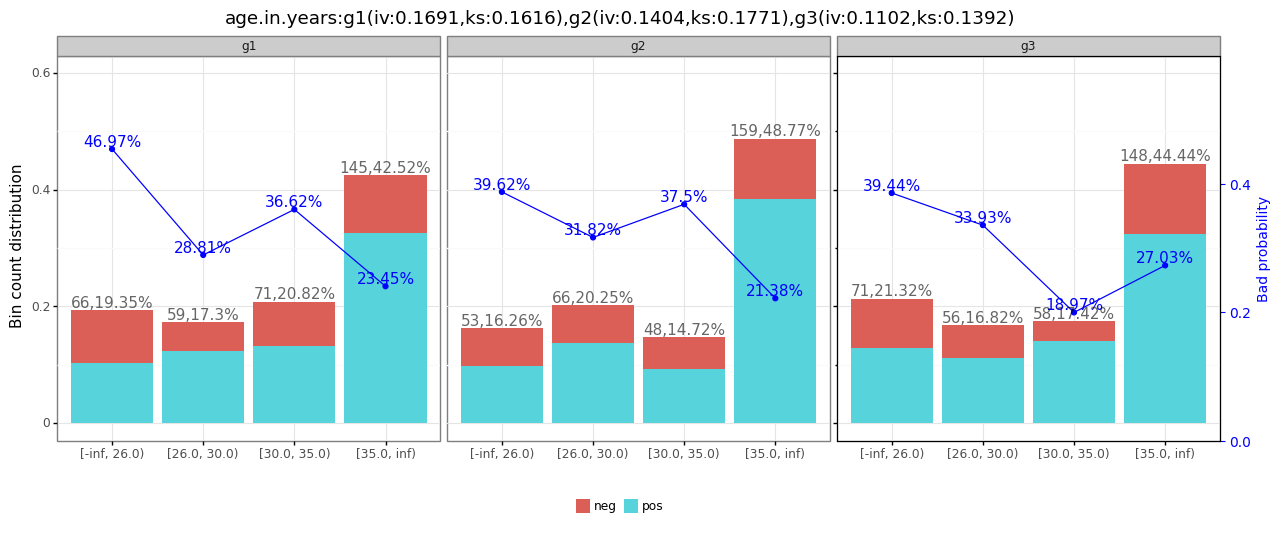

In [54]:
vtab_g_fig['age.in.years']

若希望在绘图报告中排序组水平，可使用参数sort_columns

geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


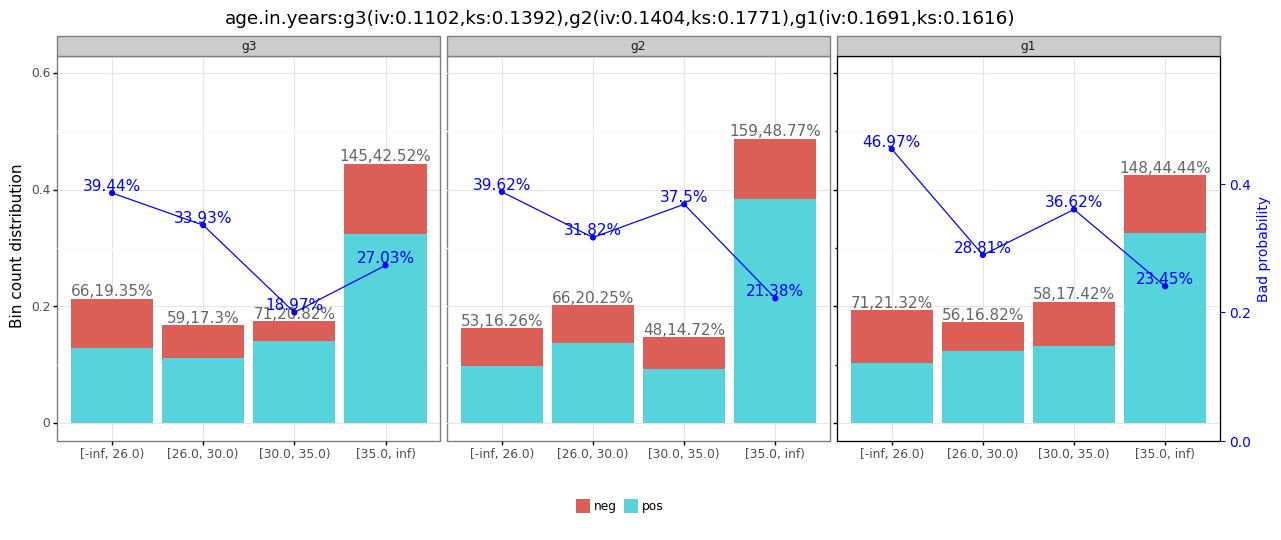

In [55]:
vtab_g_fig=varGroupsPlot(bin_tree.breaks_list,column='client_group',sort_column=['g3','g2','g1'],
                         target=y.name,n_jobs=1).plot(X_all,figure_size=(15,5))
vtab_g_fig['age.in.years']

### 1.4.8 导出为excel

varGroupsReport支持对组报告导出为excel,名称为var_report.xlsx

+ 参数out_path为报告输出路径,若无此路径则模块会创建该路径
+ 参数tab_suffix代表报告名称后缀,例如tab_suffix=‘_group’时,输出报告名称为var_report_group.xlsx
+ report_dict中所有的报告都会被导出,并写为不同的sheet

In [56]:
vtabs_g=bm.varGroupsReport(bin_tree.breaks_list,columns=['client_group'],
                           target=y.name,row_limit=0,
                           output_psi=True,n_jobs=1,
                           out_path='report/',
                           tab_suffix='_client'
                          ).fit(X_all)

to_excel done
